# Regularization and Evaluation of Neural Networks

In [11]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [12]:
digits = load_digits()
X = digits.data
y = digits.target

y_binary = y % 2

In [13]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X, y_binary, epochs=50, batch_size=10)

Epoch 1/50
180/180 [==============================] - 0s 496us/step - loss: 0.4727 - accuracy: 0.7846
Epoch 2/50
180/180 [==============================] - 0s 523us/step - loss: 0.2567 - accuracy: 0.8971
Epoch 3/50
180/180 [==============================] - 0s 507us/step - loss: 0.2018 - accuracy: 0.9221
Epoch 4/50
180/180 [==============================] - 0s 531us/step - loss: 0.1678 - accuracy: 0.9332
Epoch 5/50
180/180 [==============================] - 0s 521us/step - loss: 0.1364 - accuracy: 0.9499
Epoch 6/50
180/180 [==============================] - 0s 487us/step - loss: 0.1164 - accuracy: 0.9560
Epoch 7/50
180/180 [==============================] - 0s 557us/step - loss: 0.0973 - accuracy: 0.9616
Epoch 8/50
180/180 [==============================] - 0s 533us/step - loss: 0.0824 - accuracy: 0.9644
Epoch 9/50
180/180 [==============================] - 0s 544us/step - loss: 0.0737 - accuracy: 0.9688
Epoch 10/50
180/180 [==============================] - 0s 530us/step - loss: 0.062

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling
**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [14]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [15]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
12/12 [==============================] - 0s 635us/step - loss: 0.6954 - accuracy: 0.5039
Epoch 2/10
12/12 [==============================] - 0s 635us/step - loss: 0.6943 - accuracy: 0.5039
Epoch 3/10
12/12 [==============================] - 0s 635us/step - loss: 0.6936 - accuracy: 0.5039
Epoch 4/10
12/12 [==============================] - 0s 635us/step - loss: 0.6928 - accuracy: 0.5039
Epoch 5/10
12/12 [==============================] - 0s 635us/step - loss: 0.6922 - accuracy: 0.5039
Epoch 6/10
12/12 [==============================] - 0s 635us/step - loss: 0.6918 - accuracy: 0.5039
Epoch 7/10
12/12 [==============================] - 0s 634us/step - loss: 0.6914 - accuracy: 0.5039
Epoch 8/10
12/12 [==============================] - 0s 544us/step - loss: 0.6911 - accuracy: 0.5039
Epoch 9/10
12/12 [==============================] - 0s 635us/step - loss: 0.6907 - accuracy: 0.5039
Epoch 10/10
12/12 [==============================] - 0s 635us/step - loss: 0.6904 - accuracy: 0.5039

We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [16]:
results.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x1f79d1bba90>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.6954079866409302,
   0.6943346261978149,
   0.6935656666755676,
   0.6928132176399231,
   0.692219614982605,
   0.6918116807937622,
   0.6913874745368958,
   0.6910540461540222,
   0.6907174587249756,
   0.6903647780418396],
  'accuracy': [0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566]},
 'params': {'verbose': 1, 'epochs': 10, 'steps': 12},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

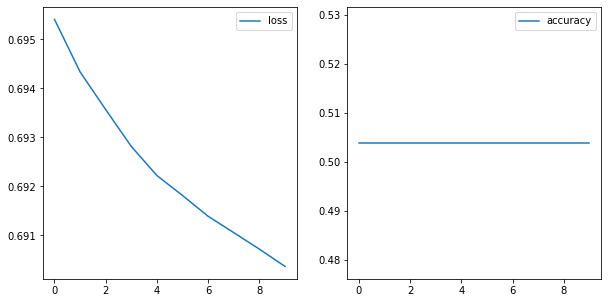

In [17]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

In [19]:
X_pure_train.shape[0]

1149

In [20]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=None, verbose=1)

Epoch 1/100
36/36 [==============================] - 0s 683us/step - loss: 0.6719 - accuracy: 0.5718
Epoch 2/100
36/36 [==============================] - 0s 598us/step - loss: 0.6589 - accuracy: 0.6432
Epoch 3/100
36/36 [==============================] - 0s 671us/step - loss: 0.6463 - accuracy: 0.6849
Epoch 4/100
36/36 [==============================] - 0s 655us/step - loss: 0.6327 - accuracy: 0.7067
Epoch 5/100
36/36 [==============================] - 0s 541us/step - loss: 0.6174 - accuracy: 0.7293
Epoch 6/100
36/36 [==============================] - 0s 546us/step - loss: 0.6002 - accuracy: 0.7502
Epoch 7/100
36/36 [==============================] - 0s 513us/step - loss: 0.5813 - accuracy: 0.7781
Epoch 8/100
36/36 [==============================] - 0s 513us/step - loss: 0.5607 - accuracy: 0.7903
Epoch 9/100
36/36 [==============================] - 0s 551us/step - loss: 0.5382 - accuracy: 0.8007
Epoch 10/100
36/36 [==============================] - 0s 541us/step - loss: 0.5151 - accura

36/36 [==============================] - 0s 541us/step - loss: 0.1585 - accuracy: 0.9286
Epoch 82/100
36/36 [==============================] - 0s 627us/step - loss: 0.1582 - accuracy: 0.9312
Epoch 83/100
36/36 [==============================] - 0s 541us/step - loss: 0.1557 - accuracy: 0.9330
Epoch 84/100
36/36 [==============================] - 0s 541us/step - loss: 0.1558 - accuracy: 0.9330
Epoch 85/100
36/36 [==============================] - 0s 513us/step - loss: 0.1548 - accuracy: 0.9330
Epoch 86/100
36/36 [==============================] - 0s 570us/step - loss: 0.1536 - accuracy: 0.9312
Epoch 87/100
36/36 [==============================] - 0s 513us/step - loss: 0.1528 - accuracy: 0.9321
Epoch 88/100
36/36 [==============================] - 0s 541us/step - loss: 0.1513 - accuracy: 0.9356
Epoch 89/100
36/36 [==============================] - 0s 513us/step - loss: 0.1510 - accuracy: 0.9356
Epoch 90/100
36/36 [==============================] - 0s 513us/step - loss: 0.1495 - accuracy: 

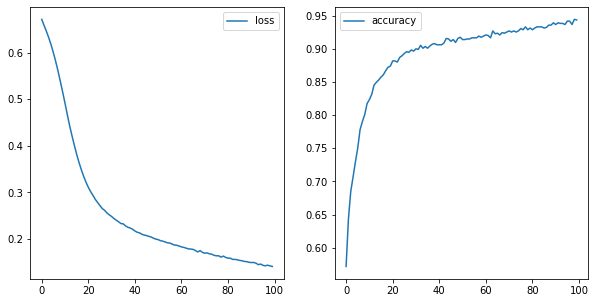

In [21]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

C:\Users\IM\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
115/115 [==============================] - 0s 481us/step - loss: 1.3587 - accuracy: 0.4682
Epoch 2/30
115/115 [==============================] - 0s 560us/step - loss: 1.0192 - accuracy: 0.4970
Epoch 3/30
115/115 [==============================] - 0s 490us/step - loss: 0.9876 - accuracy: 0.5135
Epoch 4/30
115/115 [==============================] - 0s 472us/step - loss: 1.0113 - accuracy: 0.4883
Epoch 5/30
115/115 [==============================] - 0s 480us/step - loss: 0.9677 - accuracy: 0.4978
Epoch 6/30
115/115 [==============================] - 0s 558us/step - loss: 0.9650 - accuracy: 0.5048
Epoch 7/30
115/115 [==============================] - 0s 563us/step - loss: 0.9537 - accuracy: 0.5126
Epoch 8/30
115/115 [==============================] - 0s 587us/step - loss: 0.9820 - accuracy: 0.5004
Epoch 9/30
115/115 [==============================] - 0s 625us/step - loss: 0.9557 - accuracy: 0.5170
Epoch 10/30
115/115 [==============================] - 0s 479us/step - loss: 1.041

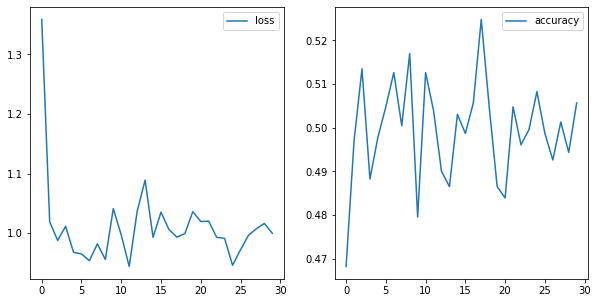

In [22]:
model = Sequential()

sgd = SGD(lr=9)
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy');

### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

Epoch 1/100
36/36 [==============================] - 1s 7ms/step - loss: 0.6463 - accuracy: 0.6205 - val_loss: 0.6202 - val_accuracy: 0.6875
Epoch 2/100
36/36 [==============================] - 0s 1ms/step - loss: 0.5804 - accuracy: 0.7206 - val_loss: 0.5607 - val_accuracy: 0.7118
Epoch 3/100
36/36 [==============================] - 0s 1ms/step - loss: 0.5123 - accuracy: 0.7746 - val_loss: 0.4926 - val_accuracy: 0.7882
Epoch 4/100
36/36 [==============================] - 0s 1ms/step - loss: 0.4517 - accuracy: 0.8138 - val_loss: 0.4281 - val_accuracy: 0.8125
Epoch 5/100
36/36 [==============================] - 0s 1ms/step - loss: 0.3941 - accuracy: 0.8381 - val_loss: 0.3624 - val_accuracy: 0.8472
Epoch 6/100
36/36 [==============================] - 0s 1ms/step - loss: 0.3368 - accuracy: 0.8616 - val_loss: 0.3101 - val_accuracy: 0.8750
Epoch 7/100
36/36 [==============================] - 0s 1ms/step - loss: 0.2895 - accuracy: 0.8903 - val_loss: 0.2703 - val_accuracy: 0.8993
Epoch 8/100
3

36/36 [==============================] - 0s 1ms/step - loss: 0.0156 - accuracy: 0.9983 - val_loss: 0.0489 - val_accuracy: 0.9757
Epoch 59/100
36/36 [==============================] - 0s 1ms/step - loss: 0.0154 - accuracy: 0.9991 - val_loss: 0.0500 - val_accuracy: 0.9792
Epoch 60/100
36/36 [==============================] - 0s 998us/step - loss: 0.0139 - accuracy: 0.9983 - val_loss: 0.0533 - val_accuracy: 0.9792
Epoch 61/100
36/36 [==============================] - 0s 1ms/step - loss: 0.0138 - accuracy: 0.9991 - val_loss: 0.0469 - val_accuracy: 0.9792
Epoch 62/100
36/36 [==============================] - 0s 997us/step - loss: 0.0137 - accuracy: 0.9991 - val_loss: 0.0544 - val_accuracy: 0.9792
Epoch 63/100
36/36 [==============================] - 0s 969us/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.0489 - val_accuracy: 0.9757
Epoch 64/100
36/36 [==============================] - 0s 997us/step - loss: 0.0130 - accuracy: 1.0000 - val_loss: 0.0500 - val_accuracy: 0.9792
Epoch 65/10

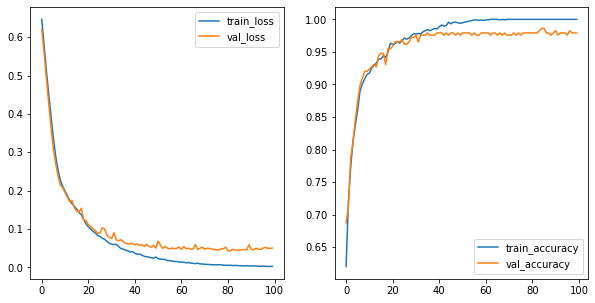

In [25]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


## YOUR CODE HERE
results = model.fit(X_pure_train, y_pure_train,
                    epochs=100,
                    batch_size=None,
                    verbose=1,
                    validation_data = (X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

In [26]:
results.history['val_accuracy'][-1]

0.9791666865348816

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [27]:
# This will throw an error.

cross_val_score(model, X_pure_train, y_pure_train)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001F79F65EF10> does not.

In [28]:
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [29]:
keras_model = scikit_learn.KerasClassifier(build_model,
                                          epochs=50,
                                          batch_size=32,
                                          verbose=2)

In [30]:
type(keras_model)

tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier

In [31]:
cross_val_score(keras_model, X_pure_train, y_pure_train)

Epoch 1/50
29/29 - 0s - loss: 0.6926 - accuracy: 0.5267
Epoch 2/50
29/29 - 0s - loss: 0.6846 - accuracy: 0.6007
Epoch 3/50
29/29 - 0s - loss: 0.6755 - accuracy: 0.6638
Epoch 4/50
29/29 - 0s - loss: 0.6632 - accuracy: 0.6464
Epoch 5/50
29/29 - 0s - loss: 0.6430 - accuracy: 0.6823
Epoch 6/50
29/29 - 0s - loss: 0.6122 - accuracy: 0.7661
Epoch 7/50
29/29 - 0s - loss: 0.5710 - accuracy: 0.7802
Epoch 8/50
29/29 - 0s - loss: 0.5283 - accuracy: 0.8172
Epoch 9/50
29/29 - 0s - loss: 0.4909 - accuracy: 0.8629
Epoch 10/50
29/29 - 0s - loss: 0.4615 - accuracy: 0.8934
Epoch 11/50
29/29 - 0s - loss: 0.4392 - accuracy: 0.8890
Epoch 12/50
29/29 - 0s - loss: 0.4189 - accuracy: 0.9064
Epoch 13/50
29/29 - 0s - loss: 0.4031 - accuracy: 0.9129
Epoch 14/50
29/29 - 0s - loss: 0.3892 - accuracy: 0.9173
Epoch 15/50
29/29 - 0s - loss: 0.3759 - accuracy: 0.9282
Epoch 16/50
29/29 - 0s - loss: 0.3635 - accuracy: 0.9271
Epoch 17/50
29/29 - 0s - loss: 0.3513 - accuracy: 0.9314
Epoch 18/50
29/29 - 0s - loss: 0.3411 - 

Epoch 44/50
29/29 - 0s - loss: 0.0775 - accuracy: 0.9717
Epoch 45/50
29/29 - 0s - loss: 0.0769 - accuracy: 0.9750
Epoch 46/50
29/29 - 0s - loss: 0.0759 - accuracy: 0.9706
Epoch 47/50
29/29 - 0s - loss: 0.0723 - accuracy: 0.9771
Epoch 48/50
29/29 - 0s - loss: 0.0713 - accuracy: 0.9761
Epoch 49/50
29/29 - 0s - loss: 0.0709 - accuracy: 0.9739
Epoch 50/50
29/29 - 0s - loss: 0.0676 - accuracy: 0.9804
8/8 - 0s - loss: 0.1226 - accuracy: 0.9435
Epoch 1/50
29/29 - 0s - loss: 0.6880 - accuracy: 0.6039
Epoch 2/50
29/29 - 0s - loss: 0.6621 - accuracy: 0.7084
Epoch 3/50
29/29 - 0s - loss: 0.6020 - accuracy: 0.7682
Epoch 4/50
29/29 - 0s - loss: 0.5134 - accuracy: 0.8303
Epoch 5/50
29/29 - 0s - loss: 0.4304 - accuracy: 0.8477
Epoch 6/50
29/29 - 0s - loss: 0.3685 - accuracy: 0.8618
Epoch 7/50
29/29 - 0s - loss: 0.3248 - accuracy: 0.8738
Epoch 8/50
29/29 - 0s - loss: 0.2867 - accuracy: 0.8825
Epoch 9/50
29/29 - 0s - loss: 0.2575 - accuracy: 0.8923
Epoch 10/50
29/29 - 0s - loss: 0.2335 - accuracy: 0.89

array([0.94782609, 0.96521741, 0.94347829, 0.94782609, 0.93449783])

## Regularization

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

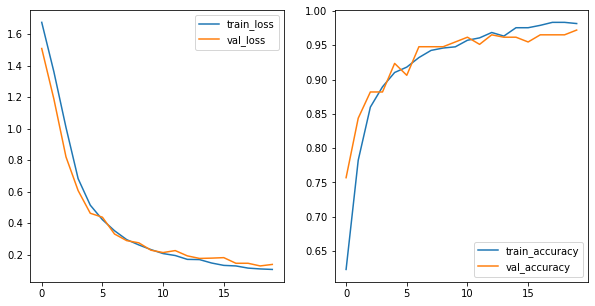

In [32]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.05)))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

Adding L2 to multiple layers:

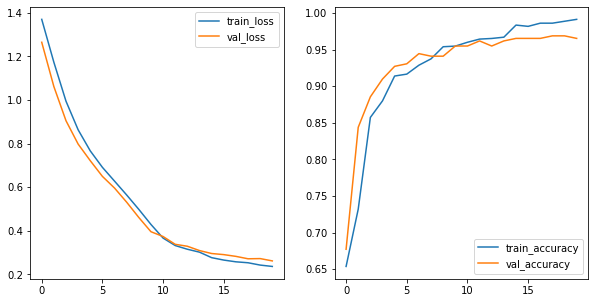

In [33]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](img/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

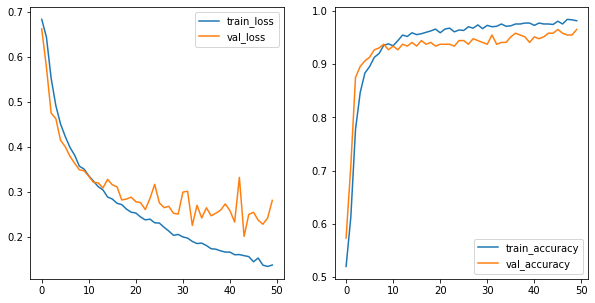

In [41]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

In [39]:
results.history['val_accuracy'][-1]

0.96875

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

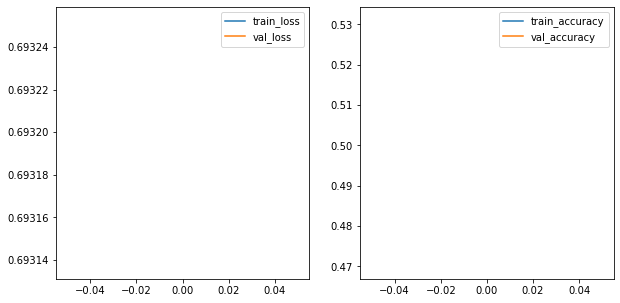

In [47]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

Epoch 00025: early stopping


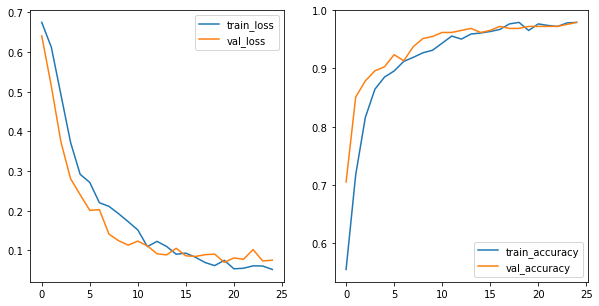

In [48]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           patience = 5,
                           verbose=1,
                           mode='min')


# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

In [49]:
results.history['val_accuracy'][-1]

0.9791666865348816

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [50]:
digits = load_digits()
X = digits.data
y = digits.target

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For a multiclass output, our neural net expects our target to be in a certain form.

In [52]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [53]:
#Columns for each digit. The 1 indicates what digit it is
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [54]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

Epoch 1/50
115/115 [==============================] - 1s 1ms/step - loss: 2.2309 - accuracy: 0.1802 - val_loss: 2.1633 - val_accuracy: 0.2396
Epoch 2/50
115/115 [==============================] - 0s 714us/step - loss: 2.0353 - accuracy: 0.3081 - val_loss: 1.9200 - val_accuracy: 0.3194
Epoch 3/50
115/115 [==============================] - 0s 689us/step - loss: 1.7259 - accuracy: 0.4134 - val_loss: 1.6153 - val_accuracy: 0.4792
Epoch 4/50
115/115 [==============================] - 0s 729us/step - loss: 1.4400 - accuracy: 0.5866 - val_loss: 1.3712 - val_accuracy: 0.5868
Epoch 5/50
115/115 [==============================] - 0s 717us/step - loss: 1.1951 - accuracy: 0.6771 - val_loss: 1.1390 - val_accuracy: 0.6736
Epoch 6/50
115/115 [==============================] - 0s 699us/step - loss: 0.9590 - accuracy: 0.7415 - val_loss: 0.9273 - val_accuracy: 0.7500
Epoch 7/50
115/115 [==============================] - 0s 702us/step - loss: 0.7714 - accuracy: 0.8094 - val_loss: 0.7588 - val_accuracy: 0

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [55]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

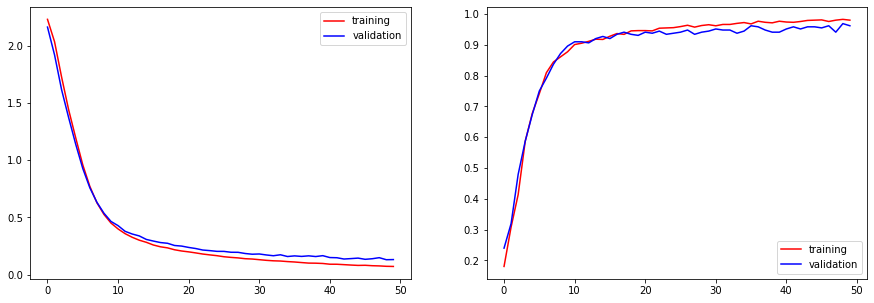

In [56]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)
ax1.legend();

In [57]:
y_hat_test = np.argmax(model.predict(X_test), axis=-1)

In [58]:
y_test_restore = ohe.inverse_transform(y_test)
confusion_matrix(y_test_restore, y_hat_test)

array([[31,  0,  0,  0,  0,  0,  1,  1,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 30,  1,  0,  0,  0,  0,  2,  0],
       [ 0,  0,  1, 32,  0,  0,  1,  0,  0,  0],
       [ 0,  1,  0,  0, 45,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0, 46,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0, 34,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 33,  0,  1],
       [ 0,  1,  1,  0,  0,  1,  0,  1, 25,  1],
       [ 0,  0,  0,  3,  0,  1,  0,  0,  2, 34]], dtype=int64)

Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

We will explore more advanced tools in the coming days.


In [ ]:
#convoluntional neural net for color images